In [37]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

from dustmaps.sfd import SFDQuery
from helpers import get_ext

In [38]:
pt_thresh = 8

Gas clouds:

In [39]:
venz = Table.read('../data/LA-clouds-Venzmer.fit')
venz_c = coord.SkyCoord(ra=venz['_RAJ2000'], dec=venz['_DEJ2000'])

In [40]:
cloud_rad = venz['Diam'] / 2

In [41]:
g = GaiaData('../data/data-joined.fits')
c = g.get_skycoord(distance=False)
mag_c = c.transform_to(gc.MagellanicStream)

In [42]:
cluster_c = coord.SkyCoord(ra=179.5*u.deg,
                           dec=-28.8*u.deg)
cluster_c.galactic

<SkyCoord (Galactic): (l, b) in deg
    ( 289.02118741,  32.62416777)>

In [43]:
ptstyle = dict(marker='.', ls='none', alpha=0.2, color='k')

In [44]:
mag_c.L.min(), mag_c.L.max()

(<Longitude 58.27105672406888 deg>, <Longitude 70.27081897905194 deg>)

In [45]:
control_mask = ( ((mag_c.L < 70.2*u.deg) & (mag_c.L > 67*u.deg)) |
                 ((mag_c.L < 60.25*u.deg) & (mag_c.L > 58.25*u.deg)) )
control_mask.sum(), 8 * (70.2-67 + 60.25-58.25)

(125420, 41.60000000000002)

### Dust-correct Gaia colors:

In [19]:
sfd = SFDQuery()
ebv = sfd.query(c)

In [20]:
Agaia = np.vstack(get_ext(g.phot_g_mean_mag.value,
                          g.phot_bp_mean_mag.value,
                          g.phot_rp_mean_mag.value,
                          ebv)).T

In [21]:
G0 = g.phot_g_mean_mag.value - Agaia[:, 0]
BP0 = g.phot_bp_mean_mag.value - Agaia[:, 1]
RP0 = g.phot_rp_mean_mag.value - Agaia[:, 2]
bprp0 = BP0 - RP0
bpg0 = BP0 - G0

In [22]:
# same area as control field
cl_mask_rad = 2.5*u.deg
cl_rough_mask = c.separation(cluster_c) < cl_mask_rad
cl_rough_mask.sum(), np.pi * (cl_mask_rad)**2

(59886, <Quantity 19.634954084936208 deg2>)

In [23]:
dark_ptstyle = dict(marker='o', markersize=2, markeredgewidth=0,
                    ls='none', alpha=0.75, color='k', rasterized=True)
pcolor_style = dict(cmap='copper', rasterized=True, linewidth=0)

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in less


157
_RAJ2000 _DEJ2000 Seq         Name            phVol      M    Diam   NH_m   Density RAJ2000 DEJ2000  HRV   Simbad
  deg      deg                             deg2 km / s  Msun  deg  1 / cm2  1 / cm3   deg     deg   km / s       
-------- -------- --- -------------------- ----------- ------ ---- -------- ------- ------- ------- ------ ------
  177.99   -29.75  21 HVC 287.8+31.4+113.8        2.86 8545.0 0.65 4.21e+18   0.002  177.99  -29.75  117.5 Simbad
_RAJ2000 _DEJ2000 Seq         Name            phVol      M    Diam   NH_m   Density RAJ2000 DEJ2000  HRV   Simbad
  deg      deg                             deg2 km / s  Msun  deg  1 / cm2  1 / cm3   deg     deg   km / s       
-------- -------- --- -------------------- ----------- ------ ---- -------- ------- ------- ------- ------ ------
  179.85   -28.58 383 HVC 289.3+32.9+250.1        0.88 4048.0 0.52 3.04e+18   0.002  179.85  -28.58  253.2 Simbad


Text(0.5,0.98,'Discovery with ${\\it Gaia}$ DR2')

/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


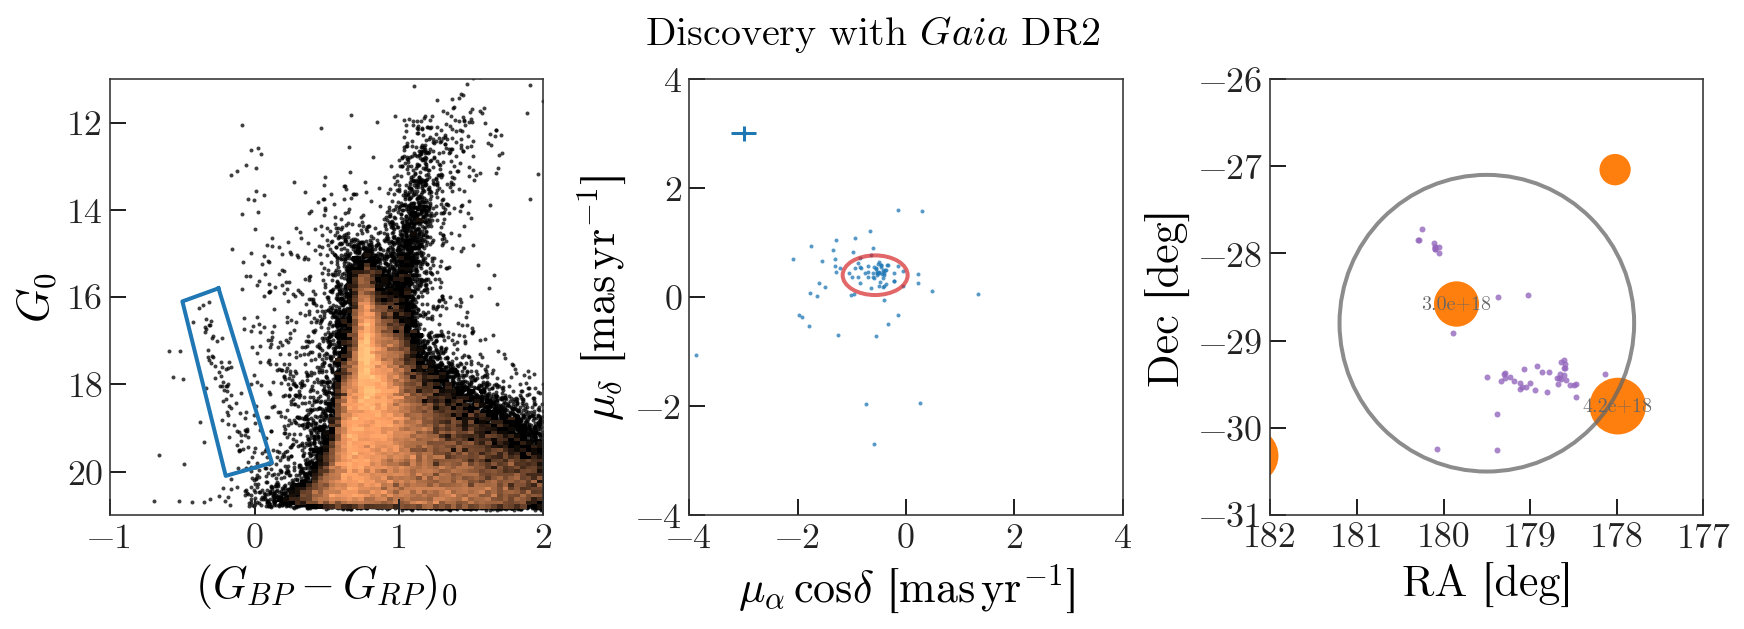

In [54]:
bins = (np.arange(-1, 2+1e-3, 0.04),
        np.arange(11, 21+1e-3, 0.08))

H, xe, ye = np.histogram2d(bprp0[cl_rough_mask], G0[cl_rough_mask],
                           bins=bins)

norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=1e2)

fig, axes = plt.subplots(1, 3, figsize=(12, 4.3), 
                         constrained_layout=True)

# ----
# CMD:
ax = axes[0]
H[H < pt_thresh] = np.nan
ax.pcolormesh(xe, ye, H.T, 
              norm=norm, **pcolor_style)
ax.plot(bprp0[cl_rough_mask], G0[cl_rough_mask], 
        zorder=-10, **dark_ptstyle)

nodes = np.array([[-0.25, 15.8],
                  [0.12, 19.8],
                  [-0.2, 20.1],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
ax.plot(nodes[:, 0], nodes[:, 1], marker='', color='tab:blue', lw=2)
cmd_path = mpl.patches.Path(nodes)

ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_ylabel('$G_0$')

ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

# --------------
# Proper motion:

X = np.vstack((bprp0, G0)).T
poly_mask = cmd_path.contains_points(X)
print(poly_mask.sum())

ax = axes[1]
style = dark_ptstyle.copy()
style['color'] = 'tab:blue'
ax.plot(g.pmra[cl_rough_mask & poly_mask], g.pmdec[cl_rough_mask & poly_mask], 
        zorder=-10, **style)
# cb = fig.colorbar(cs, ax=all_axes[:, 1])
# cb.set_label('$N$ stars')

# Plot selection ellipse
pm0 = (-0.57, 0.4)

# Plot typical error
_mask = np.sqrt( (g.pmra.value-pm0[0])**2 + (g.pmdec.value-pm0[1])**2 ) < 1
pmra_err = np.nanmean(g.pmra_error[cl_rough_mask & poly_mask & _mask & (G0 < 19.)].value)
pmdec_err = np.nanmean(g.pmdec_error[cl_rough_mask & poly_mask & _mask & (G0 < 19.)].value)
ax.errorbar(-3, 3, 
            xerr=pmra_err, yerr=pmdec_err, 
            marker='.', ls='none', 
            alpha=1, color='tab:blue')

# PM ellipse axis ratios
pmrx = 0.6
pmry = pmrx * pmdec_err / pmra_err
pm_circ = mpl.patches.Ellipse(pm0, width=2*pmrx, height=2*pmry,
                              edgecolor='tab:red', facecolor='none', 
                              linewidth=2, alpha=0.7)

ax.add_patch(pm_circ)
pm_mask = np.sqrt( (g.pmra.value-pm0[0])**2/pmrx**2 + (g.pmdec.value-pm0[1])**2/pmry**2 ) < 1.

masyr = ' [{0:latex_inline}]'.format(u.mas/u.yr)
ax.set_xlabel(r'$\mu_\alpha \, \cos \delta$' + masyr)
ax.set_ylabel(r'$\mu_\delta$' + masyr)

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)


# -------
# On sky:

ax = axes[2]

x = g.ra.value[cl_rough_mask & poly_mask & pm_mask]
y = g.dec.value[cl_rough_mask & poly_mask & pm_mask]

style = dark_ptstyle.copy()
style['color'] = 'tab:purple'
style['alpha'] = 0.8
style['markersize'] = 3.
ax.plot(x, y, **style)

# Add circle defining new cluster center and selection for DECam
sky_circ = mpl.patches.Circle((179.5, -28.8), radius=1.7, 
                              facecolor='none', edgecolor='#666666', 
                              alpha=0.75, linewidth=2, zorder=-10)
ax.add_patch(sky_circ)

# Add circles for known clouds
for i in range(len(venz)):
    cloud_circ = mpl.patches.Circle((venz_c.ra.degree[i], venz_c.dec.degree[i]),
                                    cloud_rad[i], zorder=-100, color='tab:orange',
                                    linewidth=0)
    ax.add_patch(cloud_circ)
    
    if np.sqrt((venz_c.ra.degree[i] - 179.5)**2 + (venz_c.dec.degree[i] - -28.8)**2) < 2:
        ax.text(venz_c.ra.degree[i], venz_c.dec.degree[i], 
                '{:.1e}'.format(venz['NH_m'][i]),
                ha='center', va='center', color='#666666')
        print(venz[i])

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.set_xlim(179.5 + 2.5, 179.5 - 2.5)
ax.set_ylim(-28.5 - 2.5, -28.5 + 2.5)
ax.set_xticks(np.arange(177, 182+1e-3, 1))

fig.suptitle(r'Discovery with ${\it Gaia}$ DR2', 
             fontsize=20)

# fig.savefig('../plots/figures/gaia-cmd-pm.pdf', dpi=200)

In [59]:
test = coord.SkyCoord(ra=177.99*u.deg, dec=-28.58*u.deg, distance=30*u.kpc,
                      pm_ra_cosdec=0*u.mas/u.yr, pm_dec=0*u.mas/u.yr,
                      radial_velocity=253*u.km/u.s)

In [60]:
test.transform_to(coord.LSR)

<SkyCoord (LSR: v_bary=( 11.1,  12.24,  7.25) km / s): (ra, dec, distance) in (deg, deg, kpc)
    ( 177.99, -28.58,  30.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    ( 0.11669445,  0.04461574,  249.8508156)>

In [23]:
tbl = g[cl_rough_mask & poly_mask & pm_mask].data
tbl['G0'] = G0[cl_rough_mask & poly_mask & pm_mask]
tbl['BP0'] = BP0[cl_rough_mask & poly_mask & pm_mask]
tbl['RP0'] = RP0[cl_rough_mask & poly_mask & pm_mask]
tbl.write('../data/products/gaia-selected.fits', overwrite=True)

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in less


157


/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


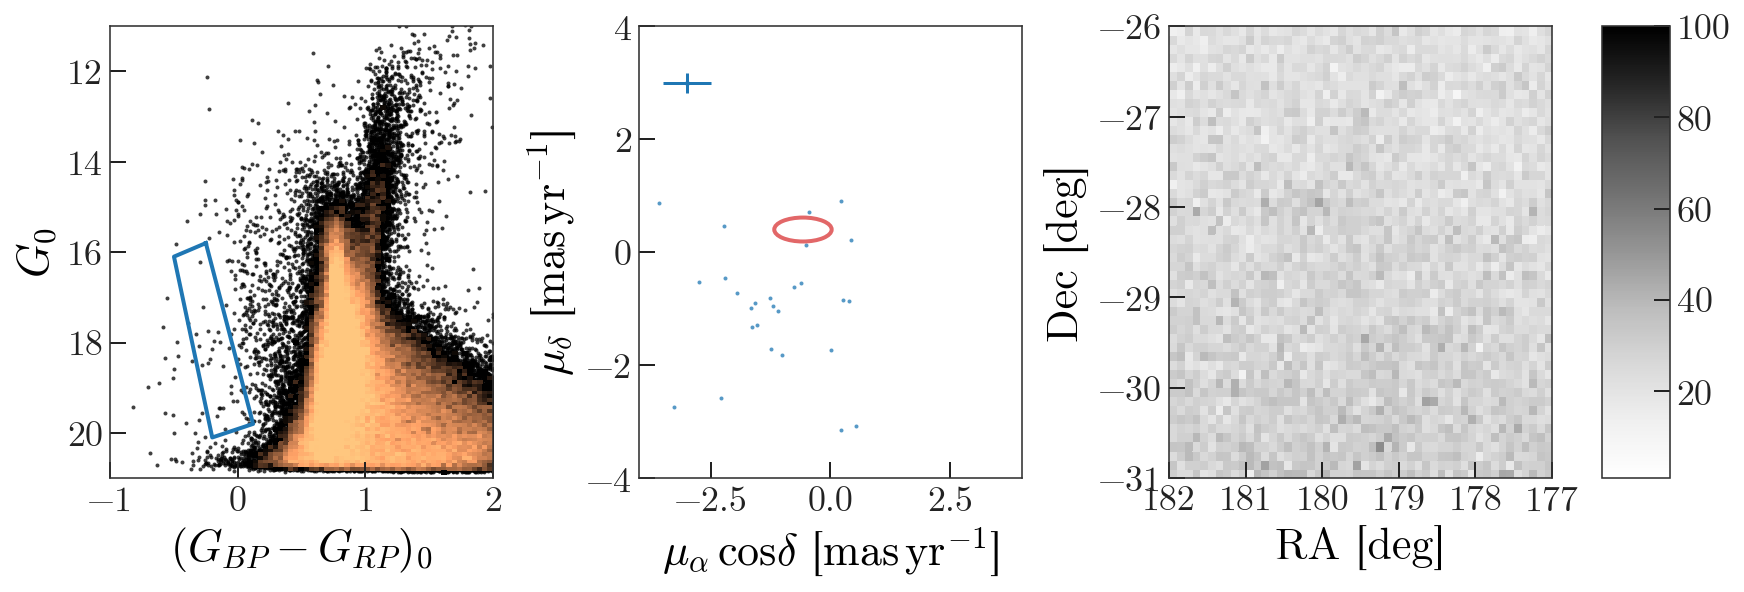

In [100]:
H, xe, ye = np.histogram2d(bprp0[control_mask], G0[control_mask],
                           bins=bins)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                         constrained_layout=True)

# ----
# CMD:
ax = axes[0]
H[H < pt_thresh] = np.nan
ax.pcolormesh(xe, ye, H.T, 
              norm=norm, **pcolor_style)
ax.plot(bprp0[control_mask], G0[control_mask], 
        zorder=-10, **dark_ptstyle)

nodes = np.array([[-0.25, 15.8],
                  [0.12, 19.8],
                  [-0.2, 20.1],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
ax.plot(nodes[:, 0], nodes[:, 1], marker='', color='tab:blue', lw=2)
cmd_path = mpl.patches.Path(nodes)

ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_ylabel('$G_0$')

ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

# --------------
# Proper motion:

X = np.vstack((bprp0, G0)).T
poly_mask = cmd_path.contains_points(X)
print(poly_mask.sum())

ax = axes[1]
style = dark_ptstyle.copy()
style['color'] = 'tab:blue'
ax.plot(g.pmra[control_mask & poly_mask], g.pmdec[control_mask & poly_mask], 
        zorder=-10, **style)

# Plot typical error
_mask = np.sqrt( (g.pmra.value-pm0[0])**2 + (g.pmdec.value-pm0[1])**2 ) < pmr
pmra_err = np.nanmean(g.pmra_error[control_mask & poly_mask & _mask & (G0 < 19.)].value)
pmdec_err = np.nanmean(g.pmdec_error[control_mask & poly_mask & _mask & (G0 < 19.)].value)
ax.errorbar(-3, 3, 
            xerr=pmra_err, yerr=pmdec_err, 
            marker='.', ls='none', 
            alpha=1, color='tab:blue')
# cb = fig.colorbar(cs, ax=all_axes[:, 1])
# cb.set_label('$N$ stars')

# Plot selection ellipse
pm0 = (-0.57, 0.4)
pmrx = 0.6
pmry = pmrx * pmdec_err / pmra_err
pm_circ = mpl.patches.Ellipse(pm0, width=2*pmrx, height=2*pmry,
                              edgecolor='tab:red', facecolor='none', 
                              linewidth=2, alpha=0.7)
ax.add_patch(pm_circ)
pm_mask = np.sqrt( (g.pmra.value-pm0[0])**2/pmrx**2 + (g.pmdec.value-pm0[1])**2/pmry**2 ) < 1.

masyr = ' [{0:latex_inline}]'.format(u.mas/u.yr)
ax.set_xlabel(r'$\mu_\alpha \, \cos \delta$' + masyr)
ax.set_ylabel(r'$\mu_\delta$' + masyr)

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)


# -------
# On sky:

ax = axes[2]

x = g.ra.value
y = g.dec.value
bins = (np.arange(179.5 - 2.5, 179.5 + 2.5+1e-3, 0.1),
        np.arange(-28.5 - 2.5, -28.5 + 2.5+1e-3, 0.1))
Hsky, xesky, yesky = np.histogram2d(x, y, bins=bins)
cs = ax.pcolormesh(xesky, yesky, Hsky.T, cmap='Greys', 
                   vmin=1, vmax=100)
#                    norm=mpl.colors.LogNorm(vmin=1, vmax=2e2))
fig.colorbar(cs)
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.set_xlim(179.5 + 2.5, 179.5 - 2.5)
ax.set_ylim(-28.5 - 2.5, -28.5 + 2.5)
ax.set_xticks(np.arange(177, 182+1e-3, 1))

fig.savefig('../plots/figures/gaia-cmd-pm-control.pdf', dpi=200)

---

### What's up with that over-density near (180, -28)

In [77]:
c2 = coord.SkyCoord(ra=180*u.deg, dec=-28*u.deg)
c2_mask = c.separation(c2) < 0.2*u.deg
c2_mask.sum()

430

In [81]:
pm0

(-0.57, 0.4)

In [86]:
c2_pm_mask = np.sqrt((g.pmra.value--0.57)**2 + (g.pmdec.value-0.2)**2) < 1.

(-5, 5)

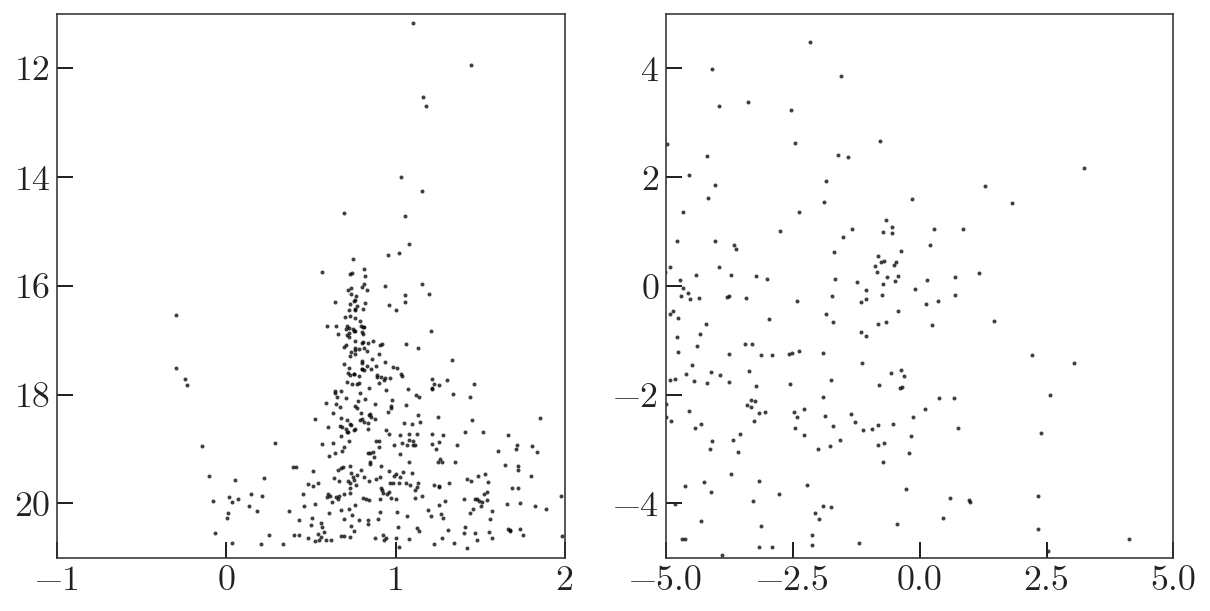

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.plot(bprp0[c2_mask], G0[c2_mask], 
        zorder=-10, **dark_ptstyle)
ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

ax = axes[1]
ax.plot(g.pmra[c2_mask], g.pmdec[c2_mask], 
        zorder=-10, **dark_ptstyle)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

(21, 11)

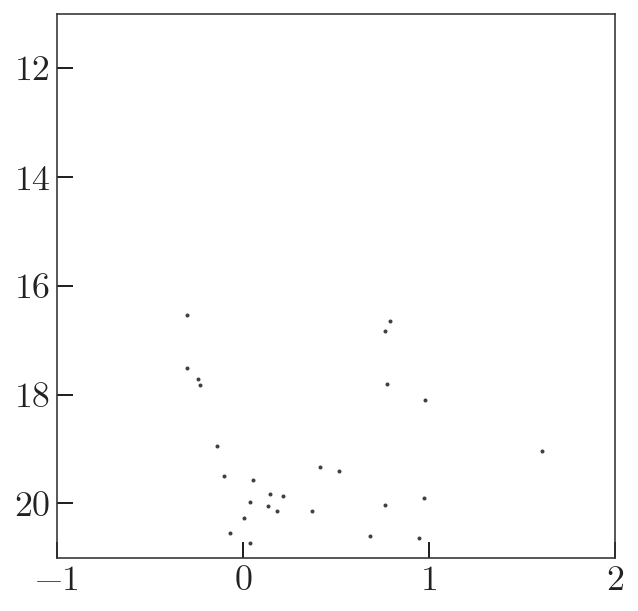

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(bprp0[c2_mask & c2_pm_mask], G0[c2_mask & c2_pm_mask], 
        zorder=-10, **dark_ptstyle)
ax.set_xlim(-1, 2)
ax.set_ylim(21, 11)

# deimos

In [47]:
x = g.ra.value[cl_rough_mask & poly_mask & pm_mask]
y = g.dec.value[cl_rough_mask & poly_mask & pm_mask]

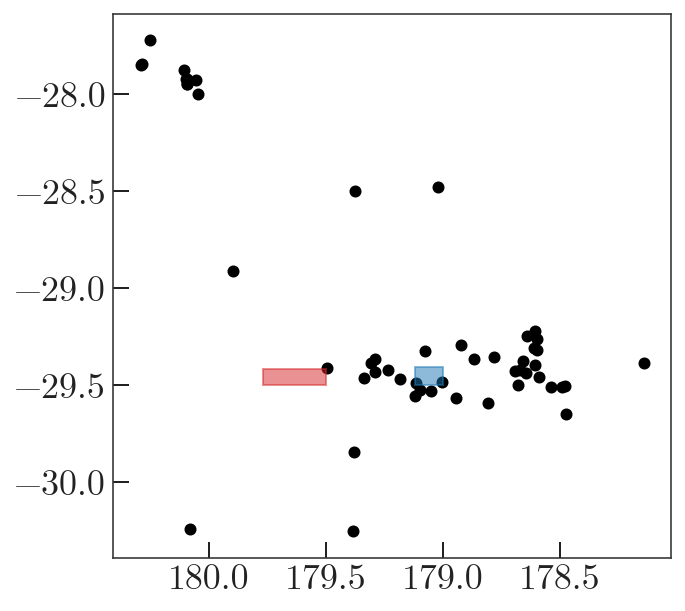

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(x, y, c='k')
ax.invert_xaxis()

rect = mpl.patches.Rectangle((179.5, -29.5), 16/60., 5/60., color='tab:red', alpha=0.5)
ax.add_patch(rect)

rect = mpl.patches.Rectangle((179., -29.5), 7.2/60., 5.7/60., color='tab:blue', alpha=0.5)
ax.add_patch(rect)